In [25]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

In [26]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [19]:
# Configuración general
csv_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\objective2_data_cleaned\Cocoa_aSiMicro03036.csv"

# 📥 Cargar un único CSV
df = pd.read_csv(csv_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')

# 🔍 Separar features y target
X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y = df['Pmp (W)'].values.astype(np.float32)

# ⚙️ Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📦 Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)  # Para que sea shape (N, 1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

In [20]:
# 🔵 Modelo simple
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# 📐 Crear modelo
input_dim = X_train.shape[1]
model = SimpleDNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleDNN(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

C:\Users\Ibon\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Loss: 6.6885
Epoch [2/150], Loss: 6.2505
Epoch [3/150], Loss: 7.1609
Epoch [4/150], Loss: 5.7659
Epoch [5/150], Loss: 6.5057
Epoch [6/150], Loss: 6.5859
Epoch [7/150], Loss: 6.3186
Epoch [8/150], Loss: 7.2894
Epoch [9/150], Loss: 6.5714
Epoch [10/150], Loss: 6.5590
Epoch [11/150], Loss: 6.3127
Epoch [12/150], Loss: 5.3939
Epoch [13/150], Loss: 5.2615
Epoch [14/150], Loss: 5.9404
Epoch [15/150], Loss: 6.0174
Epoch [16/150], Loss: 5.5082
Epoch [17/150], Loss: 5.4669
Epoch [18/150], Loss: 5.5931
Epoch [19/150], Loss: 5.4952
Epoch [20/150], Loss: 5.3051
Epoch [21/150], Loss: 5.5288
Epoch [22/150], Loss: 4.9632
Epoch [23/150], Loss: 5.0692
Epoch [24/150], Loss: 5.2985
Epoch [25/150], Loss: 5.3233
Epoch [26/150], Loss: 5.3401
Epoch [27/150], Loss: 5.3992
Epoch [28/150], Loss: 5.5625
Epoch [29/150], Loss: 5.0305
Epoch [30/150], Loss: 5.2903
Epoch [31/150], Loss: 4.9945
Epoch [32/150], Loss: 4.8958
Epoch [33/150], Loss: 5.0819
Epoch [34/150], Loss: 4.8431
Epoch [35/150], Loss: 5

C:\Users\Ibon\AppData\Local\Temp\ipykernel_24336\3691599985.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_onecsv.pth"))


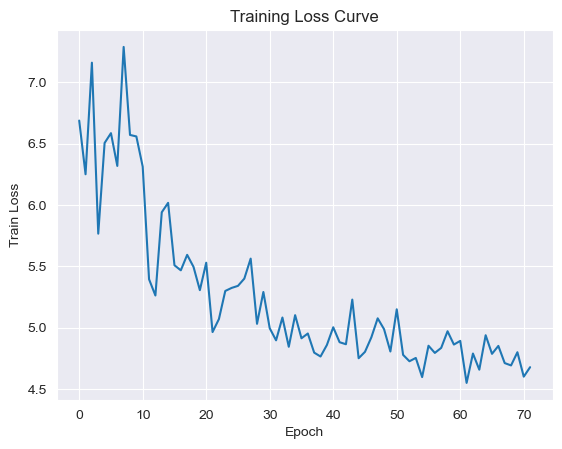

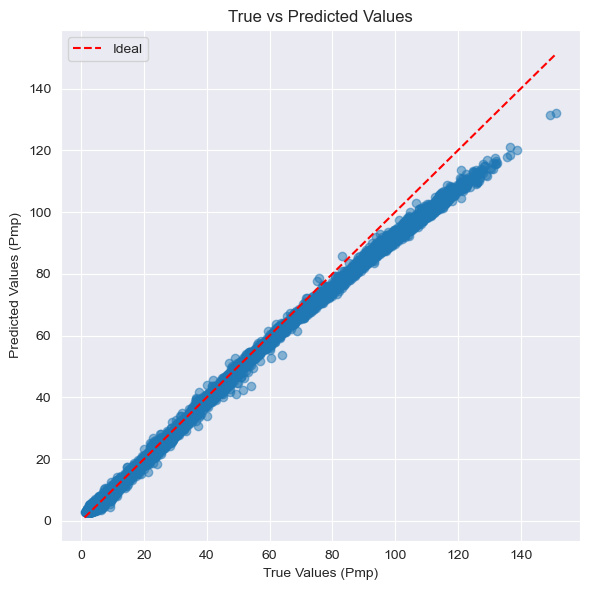

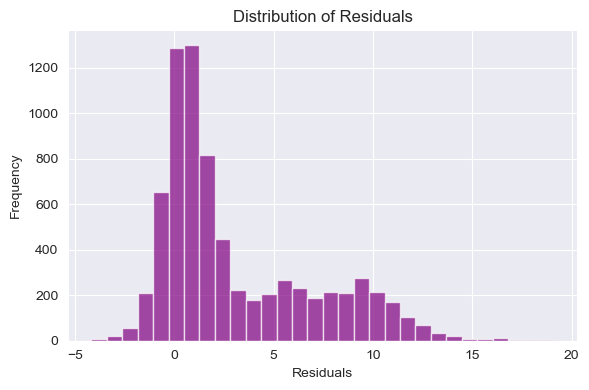

In [28]:
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
criterion = nn.MSELoss()

epochs = 150
best_loss = np.inf
patience = 10
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_onecsv.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model_onecsv.pth"))

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    residuals = y_test_np - y_pred

# 📈 Gráfica de la pérdida
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 📈 Scatter plot: Predicciones vs Reales
plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', label='Ideal')
plt.xlabel("True Values (Pmp)")
plt.ylabel("Predicted Values (Pmp)")
plt.title("True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

 # OPTUNA

In [22]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

In [23]:


def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    n_layers = trial.suggest_int("n_layers", 3, 6)
    hidden_size = trial.suggest_int("hidden_size", 64, 512)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)

    # Red neuronal dinámica según Optuna
    layers = []
    input_dim_aux = input_dim  # input_dim debe estar definido antes
    for i in range(n_layers):
        layers.append(nn.Linear(input_dim_aux, hidden_size))
        layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        input_dim_aux = hidden_size
    layers.append(nn.Linear(hidden_size, 1))

    model = nn.Sequential(*layers).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(50):
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)

    # Validación final en GPU
    model.eval()
    with torch.no_grad():
        X_test_cuda = X_test_tensor.to(device)
        y_pred = model(X_test_cuda).cpu().numpy()
        mse = mean_squared_error(y_test_np, y_pred)

    return mse

# Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  MSE: {trial.value}")
for key, value in trial.params.items():
    print(f"  {key}: {value}")


[I 2025-03-24 14:13:33,878] A new study created in memory with name: no-name-1592eeba-c911-4260-81f7-e923522e7c38
C:\Users\Ibon\AppData\Local\Temp\ipykernel_24336\3990015023.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
C:\Users\Ibon\AppData\Local\Temp\ipykernel_24336\3990015023.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
[I 2025-03-24 14:14:26,098] Trial 0 finished with value: 1.6979937553405762 and parameters: {'n_layers': 4, 'hidden_size': 222, 'dropout_rate': 0.34819353747745907, 'lr': 0.00414429693191443, 'weight_decay': 1.95371479323498

KeyboardInterrupt: 